# Plot usage heatmaps for some example sessions, along with 5 minute binned transition matrices

In [1]:
import toml
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from rl_analysis import ANALYSIS_CONFIG
from rl_analysis.behavior.moseq import syll_onset
from rl_analysis.plotting import save_factory, setup_plotting_env, fg

In [2]:
with open(ANALYSIS_CONFIG, 'r') as f:
    config = toml.load(f)

In [3]:
setup_plotting_env()
saver = save_factory(join(config['figures']['store_dir'], 'fig-s02'), tight_layout=False)

In [4]:
use_session = '58811f37-e289-40df-90c4-0d12ebef3bc5'

In [5]:
def session_filter(df):
    df = df[df['uuid'] == use_session]
    return df.copy()

In [6]:
srting = joblib.load(join(config['intermediate_results']['dlight'], 'fig1-syllable-sorting.p'))

In [7]:
df = pd.read_parquet(
    join(config['raw_data']['dlight'], 'dlight_photometry_processed_full.parquet'),
    filters=[("uuid", "=", use_session), ("area", "=", "dls")],
)
df = df.sort_index()

df['offline onset'] = False
df.loc[df.index[syll_onset(df['predicted_syllable (offline)'])], 'offline onset'] = True

In [8]:
def stride_window(a, w=4, o=2, copy=False):
    sh = (a.size - w + 1, w)
    st = a.strides * 2
    view = np.lib.stride_tricks.as_strided(a, strides=st, shape=sh)[0 :: (w - o - 1)]
    if copy:
        return view.copy()
    else:
        return view[:, [0, -1]]

In [9]:
windows = stride_window(np.arange(1801), w=6*60 + 1, o=360-16)

usages = []
for start, end in windows:
    sample = df.query("@start < timestamp < @end")
    usages.append(
        sample.loc[sample["offline onset"], "predicted_syllable (offline)"]
        .value_counts()
        .reindex(np.arange(100))
        .fillna(0)
    )
usages = np.array(usages)

In [10]:
_sorting = np.argsort(usages.mean(0))[::-1]

time_start, time_end = windows[[0, -1]].mean(axis=1)

# filter sorting by relabel map
_sorting2 = list(filter(lambda v: v in srting, _sorting))

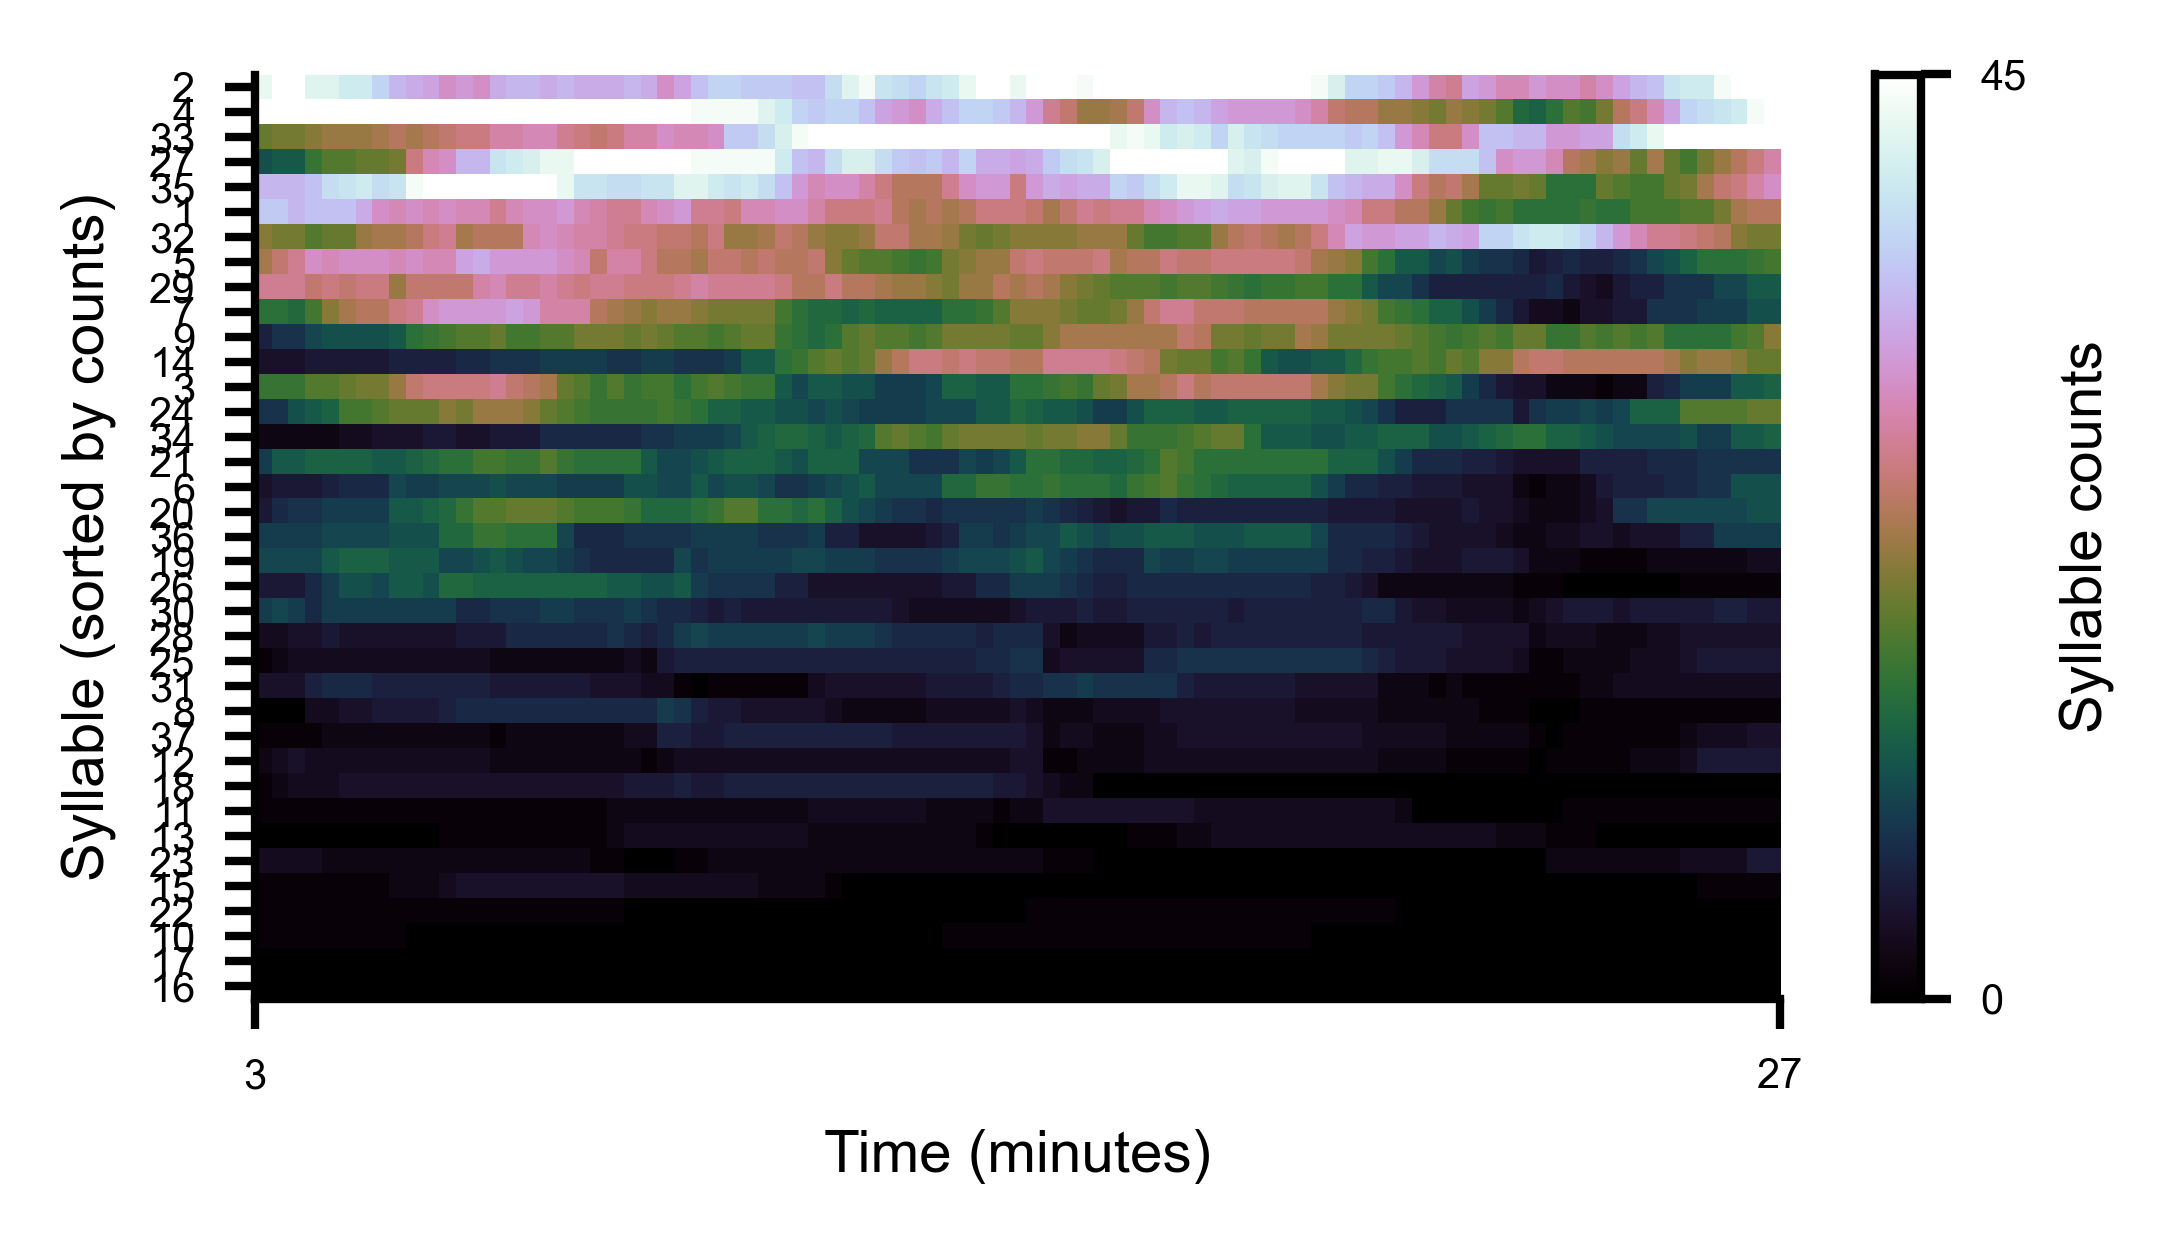

In [11]:
fig = fg(4.1, 2)
fig.dpi = 300

plt.imshow(
    usages[:, _sorting2].T,
    aspect="auto",
    cmap="cubehelix",
    extent=(time_start / 60, time_end / 60, len(_sorting2), 0),
    vmax=45,
    interpolation="none",
)
cb = plt.colorbar(label="Syllable counts")
cb.set_ticks([0, 45])
plt.xlabel("Time (minutes)")
plt.ylabel("Syllable (sorted by counts)")
plt.xticks([time_start / 60, time_end / 60])
plt.yticks(np.arange(len(_sorting2)) + 0.5,  [srting[s] + 1 for s in _sorting2])
sns.despine()
saver(fig, "example-session-usage-variability-raw");